<a href="https://colab.research.google.com/github/jonelrelucio/AN2DL-2025/blob/testing/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import os
from itertools import product



from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from sklearn.metrics import f1_score

SEED = 100

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.8.0+cu126
Device: cpu


In [3]:
df_train = pd.read_csv('pirate_pain_train.csv')

float_cols = df_train.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_train[col] = df_train[col].astype(np.float32)

df_train.head()


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [4]:
df_labels = pd.read_csv('pirate_pain_train_labels.csv')
df_labels.head()



,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [5]:
label_counts = df_labels['label'].value_counts()
display(label_counts)

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [7]:
df_high_pain = df_labels[df_labels['label'] == 'high_pain'].sample(n=56, random_state=SEED)
df_low_pain = df_labels[df_labels['label'] == 'low_pain'].sample(n=56, random_state=SEED)
df_no_pain = df_labels[df_labels['label'] == 'no_pain'].sample(n=56, random_state=SEED)

df_labels_subset = pd.concat([df_high_pain, df_low_pain, df_no_pain])

# Shuffle the subset to mix the categories
df_labels_subset = df_labels_subset.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(df_labels_subset['label'].value_counts())
display(df_labels_subset.head())

label
low_pain     56
no_pain      56
high_pain    56
Name: count, dtype: int64


,sample_index,label
0,265,low_pain
1,558,low_pain
2,547,no_pain
3,617,no_pain
4,386,high_pain


In [8]:
df_merged = pd.merge(df_train, df_labels_subset, on='sample_index')
display(df_merged.head())

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,2,0,1,1,1,2,two,two,two,0.170677,...,1.183228e-06,2.236364e-06,9.688514e-08,5.987389e-07,0.193762,0.115937,0.039989,0.032033,0.5,low_pain
1,2,1,1,0,1,2,two,two,two,0.096610,...,6.193147e-06,5.763559e-07,5.788581e-07,0.000000e+00,0.067793,0.080708,0.025002,0.043367,0.5,low_pain
2,2,2,0,0,1,2,two,two,two,0.126589,...,3.394389e-06,3.201874e-07,1.044321e-07,0.000000e+00,0.307726,0.183853,0.011395,0.052337,0.5,low_pain
3,2,3,1,1,1,2,two,two,two,0.141733,...,7.526107e-07,3.220973e-07,1.081788e-07,0.000000e+00,0.296419,0.104598,0.023226,0.011347,0.5,low_pain
4,2,4,1,1,1,2,two,two,two,0.185226,...,1.987110e-07,4.130764e-07,1.377496e-06,0.000000e+00,0.186223,0.074708,0.056673,0.054481,0.5,low_pain


In [9]:
nan_counts = df_merged.isnull().sum()
display(nan_counts[nan_counts > 0])

,0
joint_11,1
joint_12,1
joint_13,1
joint_14,1
joint_15,1
joint_16,1
joint_17,1
joint_18,1
joint_19,1
joint_20,1


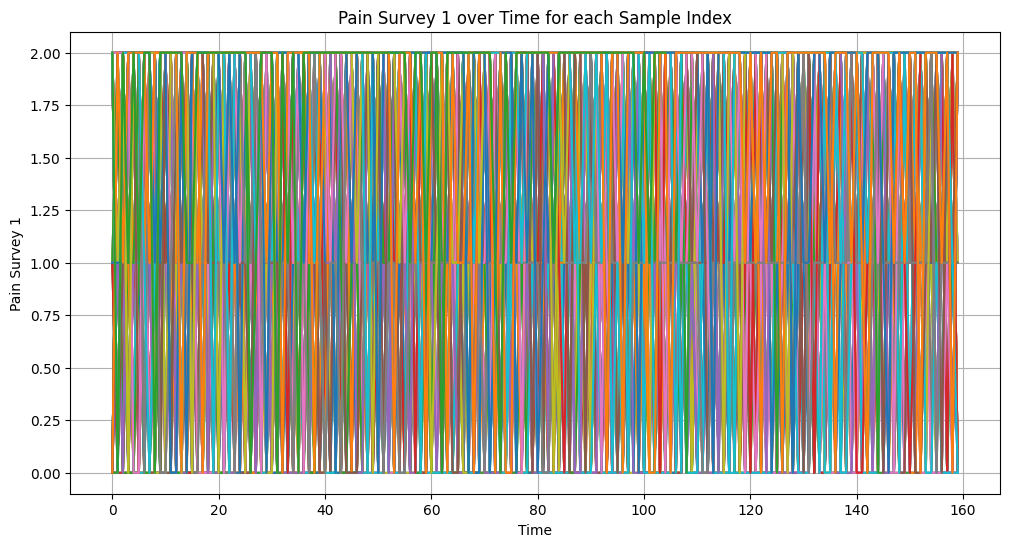

In [10]:
plt.figure(figsize=(12, 6))
for sample_idx in df_merged['sample_index'].unique():
    subset = df_merged[df_merged['sample_index'] == sample_idx]
    plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for each Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

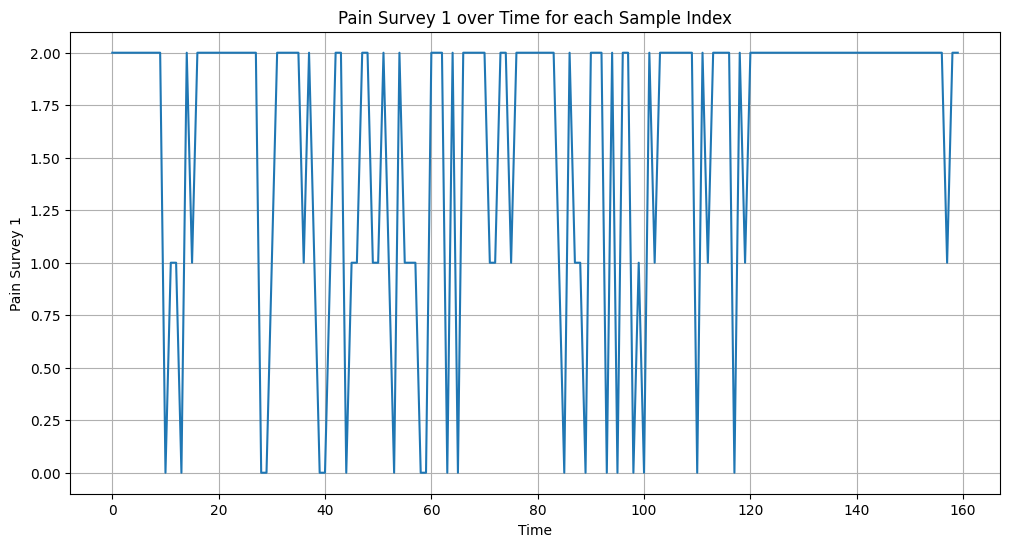

In [19]:
plt.figure(figsize=(12, 6))
sample_idx = random.choice(df_merged['sample_index'].unique())
subset = df_merged[df_merged['sample_index'] == sample_idx]
plt.plot(subset['time'], subset['pain_survey_1'], label=f'Sample {sample_idx}')

plt.xlabel('Time')
plt.ylabel('Pain Survey 1')
plt.title('Pain Survey 1 over Time for each Sample Index')
# plt.legend() # Commented out due to too many lines making legend unreadable
plt.grid(True)
plt.show()

In [20]:
label_counts = df_merged['n_legs'].value_counts()
display(label_counts)

,count
n_legs,
two,19305
one+peg_leg,320


In [21]:
label_counts = df_merged['n_eyes'].value_counts()
display(label_counts)

,count
n_eyes,
two,19305
one+eye_patch,320


In [22]:
label_counts = df_merged['n_hands'].value_counts()
display(label_counts)

,count
n_hands,
two,19305
one+hook_hand,320


In [23]:
unusual_samples = df_merged[
    (df_merged['n_eyes'] != 'two') |
    (df_merged['n_legs'] != 'two') |
    (df_merged['n_hands'] != 'two')
]

display(unusual_samples[['sample_index', 'label']].drop_duplicates().reset_index(drop=True))

,sample_index,label
0,137,no_pain
1,338,low_pain


In [26]:
unusual_samples = df_train[
    (df_train['n_eyes'] != 'two') |
    (df_train['n_legs'] != 'two') |
    (df_train['n_hands'] != 'two')
]

display(unusual_samples[['sample_index']].drop_duplicates().reset_index(drop=True))

,sample_index
0,8
1,137
2,216
3,338
4,350


In [27]:
unusual_sample_indices = unusual_samples['sample_index'].unique()
unusual_labels = df_labels[df_labels['sample_index'].isin(unusual_sample_indices)]

display(unusual_labels)

,sample_index,label
8,8,no_pain
137,137,no_pain
216,216,no_pain
338,338,low_pain
350,350,no_pain
